In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [8]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', return_X_y=True)

In [22]:
# ensures randomized order of the dataset
random_state = check_random_state(0)

# random shuffling X and y
# X is a numpy array, not a pandas DataFrame, so we need to use indices directly
permutation = random_state.permutation(len(X))
X = X[permutation]
y = y[permutation]

# Converts input features into a 2D format for logistic regression or SVMs
X = X.reshape((X.shape[0], -1))

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1)  # 10% of the training data for validation

In [15]:
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / 60000, #scales C based on the number of training samples.
                         penalty='l1', solver='saga', tol=0.1) #tol controls convergence speed (higher values make training faster but less precise)
clf.fit(X_train, y_train)

# Validate the model on validation set
val_score = clf.score(X_val, y_val)
print(f"Validation accuracy: {val_score:.4f}")


Validation accuracy: 0.8317


In [16]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to test
param_grid = {
    'C': [0.01, 0.1, 1],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'tol': [0.01, 0.1, 1]  # Convergence tolerance
}

# Create the model (without training it yet)
clf = LogisticRegression(solver='saga', max_iter=1000)

# GridSearchCV tests all combinations of hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Run grid search on the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on validation data
val_score = grid_search.best_estimator_.score(X_val, y_val)
print(f"Validation accuracy after GridSearchCV: {val_score:.4f}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..........................C=0.01, penalty=l1, tol=1; total time=   2.1s
[CV] END ..........................C=0.01, penalty=l1, tol=1; total time=   2.1s
[CV] END ..........................C=0.01, penalty=l1, tol=1; total time=   1.8s
[CV] END ........................C=0.01, penalty=l1, tol=0.1; total time=   8.5s
[CV] END ........................C=0.01, penalty=l1, tol=0.1; total time=   8.4s
[CV] END ........................C=0.01, penalty=l1, tol=0.1; total time=   8.6s
[CV] END ........................C=0.01, penalty=l2, tol=0.1; total time=   4.6s
[CV] END ........................C=0.01, penalty=l2, tol=0.1; total time=   4.7s
[CV] END ..........................C=0.01, penalty=l2, tol=1; total time=   1.0s
[CV] END ..........................C=0.01, penalty=l2, tol=1; total time=   1.0s
[CV] END ..........................C=0.01, penalty=l2, tol=1; total time=   1.1s
[CV] END ........................C=0.01, penalty

In [17]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Compare with validation accuracy
print(f"Best model validation accuracy: {val_score:.4f}")


Best model validation accuracy: 0.9107


In [18]:
# Use the best model from grid search to train on the entire training set
# First, create a new model with the best parameters
best_params = grid_search.best_params_
print(f"Training final model with parameters: {best_params}")

# Create a new model with the best parameters
clf = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    tol=best_params['tol'],
    solver='saga',
    max_iter=1000
)

# Combine training and validation sets for final training
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))

# Train on the combined dataset
clf.fit(X_train_full, y_train_full)

# Evaluate on the test set
test_score = clf.score(X_test, y_test)
print(f"Test accuracy with best model: {test_score:.4f}")


Training final model with parameters: {'C': 1, 'penalty': 'l2', 'tol': 0.01}
Test accuracy with best model: 0.9129


cmap=plt.cm.RdBu:
Red areas → Pixels that strongly indicate this digit.
Blue areas → Pixels that strongly indicate another digit.

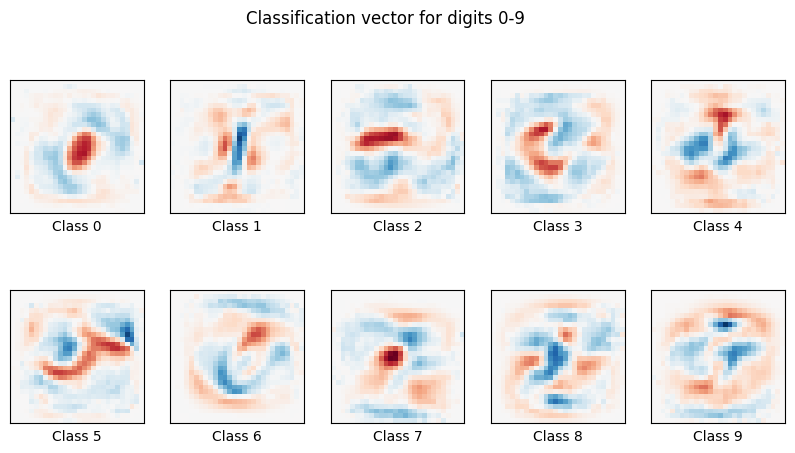

In [19]:
#clf.coef_ contains the weights learned by the LR model for each class
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10): #The dataset has 10 classes (digits 0–9 for MNIST)
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for digits 0-9')
plt.show()

<Figure size 800x600 with 0 Axes>

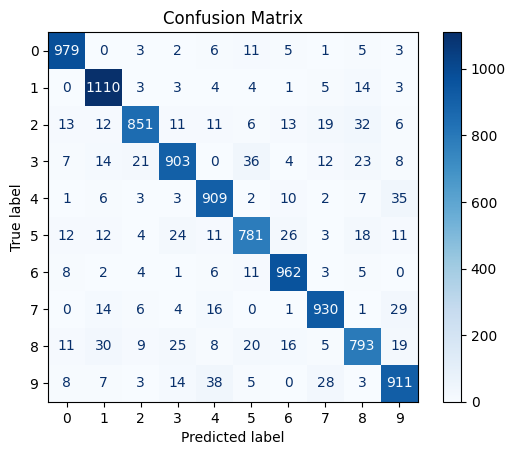

In [20]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test set
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [21]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1015
           1       0.92      0.97      0.94      1147
           2       0.94      0.87      0.90       974
           3       0.91      0.88      0.89      1028
           4       0.90      0.93      0.91       978
           5       0.89      0.87      0.88       902
           6       0.93      0.96      0.94      1002
           7       0.92      0.93      0.93      1001
           8       0.88      0.85      0.86       936
           9       0.89      0.90      0.89      1017

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

